# Imports and utility variables

In [1]:
import phoebe
from phoebe import u

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

from astropy.coordinates import SkyCoord

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
gaiaDatasets = ['lcGaiaG', 'lcGaiaRP', 'lcGaiaBP']
ztfDatasets = ['lcZtfG', 'lcZtfR']

In [3]:
objCoord = SkyCoord.from_name('ATO J339.9469+45.1464')
objCoord = SkyCoord(objCoord.ra, objCoord.dec, frame=objCoord.frame, distance=2256.9956*u.pc) # distance taken from Bailer-Jones et al. (2021)
objCoord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (339.94690379, 45.14639753, 2256.9956)>

# Load post-optimizers model

In [4]:
b = gen_utils.loadBundle(bundleName="sigma_cleaned_ztf_updated_data", parentFolder="./sampling")

# Remove all datasets except for Gaia

Only Gaia datasets have support for interstellar extinction in passband files.

In [5]:
datasetsToKeep = gaiaDatasets + ['mesh01']
for d in b.datasets:
    if d not in datasetsToKeep:
        b.remove_dataset(d)
b.datasets

['mesh01', 'lcGaiaG', 'lcGaiaRP', 'lcGaiaBP']

# Adjust `t0_supconj` to Gaia data

In [6]:
# opt_utils.optimize_params(b, fit_twigs=['t0_supconj'], label='t0_gaia', export=False, datasets=['lcGaiaG'], maxiter=20)
print(f"Original t0_supconj: {b.get_quantity(qualifier='t0_supconj')}")
b.set_value(qualifier='t0_supconj', value=0.03199*u.day) # value obtained from previous run of above optimizer; converged at 19 iterations

Original t0_supconj: 0.02589 d


100%|██████████| 104/104 [00:25<00:00,  4.09it/s]


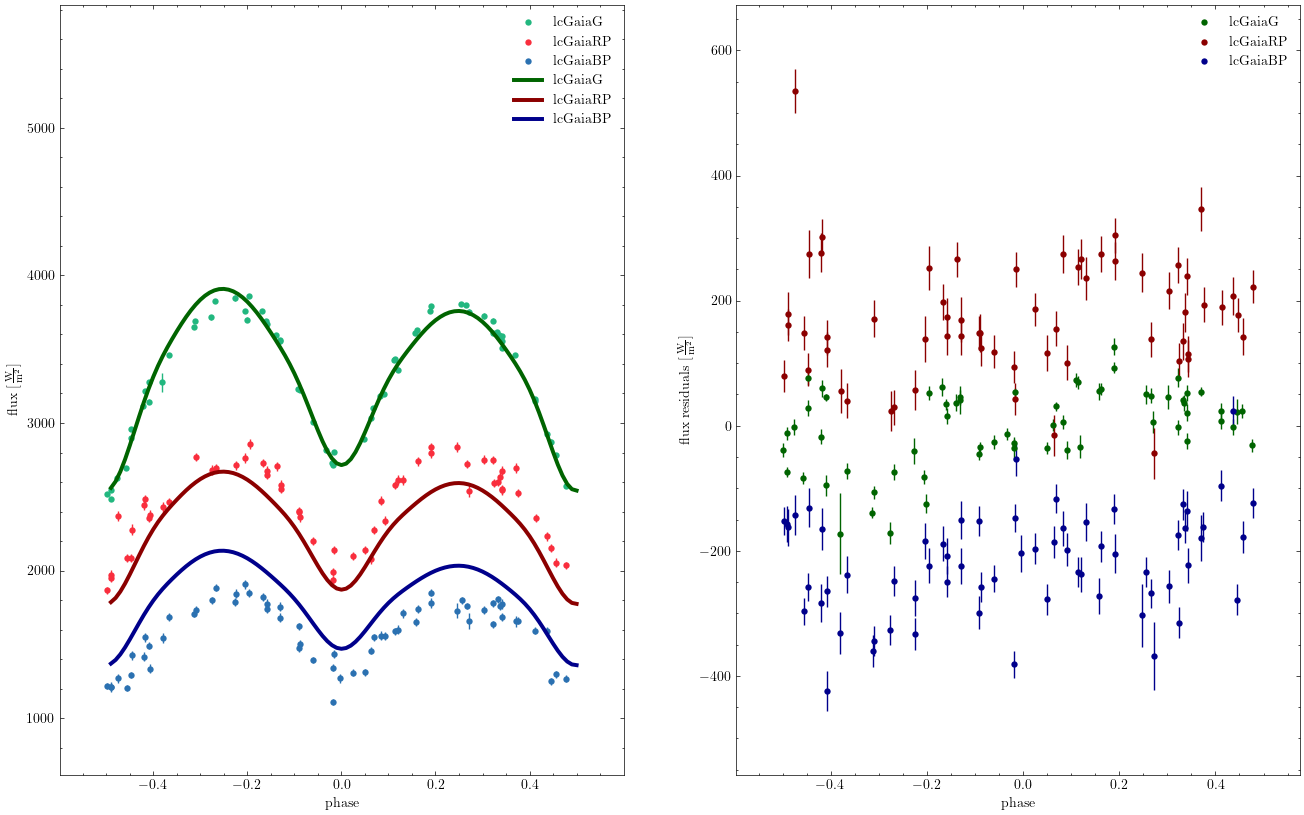

{'lcGaiaG-lcGaiaRP-lcGaiaBP': <Figure size 1600x1000 with 2 Axes>}

In [7]:
gen_utils.abilitateDatasets(b, gaiaDatasets)
if 'opt_t0_gaia_solution' in b.solutions:
    gen_utils.adopt_solution(b, solution_name='opt_t0_gaia_solution', model_name='t0_gaia_model')
else:
    b.run_compute(model='t0_gaia_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[gaiaDatasets], model='t0_gaia_model')

# Determine interstellar extinction

Utilizing 3D Bayestar dust map

In [8]:
from dustmaps.bayestar import BayestarQuery

bayestar = BayestarQuery(max_samples=50)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 23.741 s
  pix_info:   0.327 s
   samples:  13.772 s
      best:   2.701 s
       nan:   0.015 s
      sort:   6.864 s
       idx:   0.062 s


In [9]:
ebv, flags = bayestar(objCoord, mode='samples', return_flags=True)
ebv, np.mean(ebv)

(array([0.16, 0.14, 0.13, 0.14, 0.13], dtype=float32), 0.14)

## Plotting local dust map

In [10]:
raRange = np.arange(objCoord.ra.value - 5, objCoord.ra.value + 5, 0.001)
decRange = np.arange(objCoord.dec.value - 5, objCoord.dec.value + 5, 0.001)
raGrid, decGrid = np.meshgrid(raRange, decRange)

coords = SkyCoord(raGrid*u.degree, decGrid*u.degree, distance=objCoord.distance, frame=objCoord.frame)
reddening = bayestar(coords)

In [11]:
# Landolt V band from Table 6 in Schlafly & Finkbeiner (2011)
    # converting from reddening to magnitudes of Av
    # assumes Rv = 3.1
Av_LandoltV = 2.742 * reddening
Av_LandoltB = 3.626 * reddening

# Pan-Starrs 1 band g; bluest
Av_PstarG = 3.518 * reddening
Av_PstarR = 2.617 * reddening

In [12]:
print(Av_LandoltB[len(raRange)//2, len(decRange)//2])
print(Av_LandoltV[len(raRange)//2, len(decRange)//2])
print(Av_PstarG[len(raRange)//2, len(decRange)//2])
print(Av_PstarR[len(raRange)//2, len(decRange)//2])

0.50764
0.38388002
0.49251997
0.36638


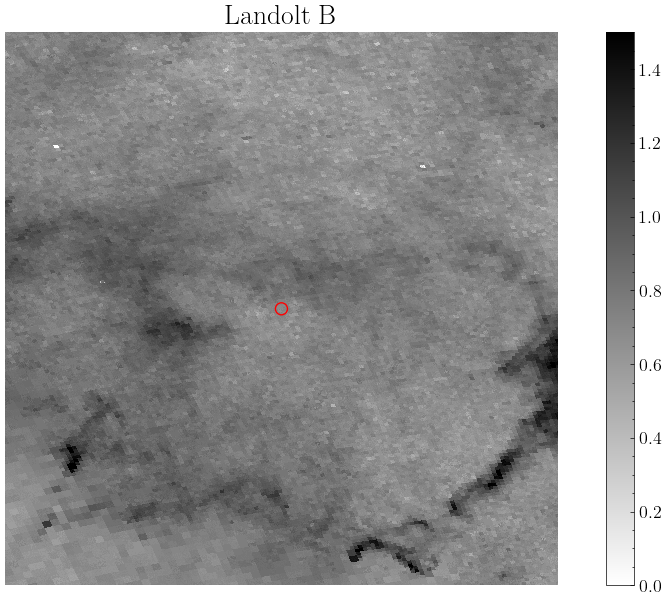

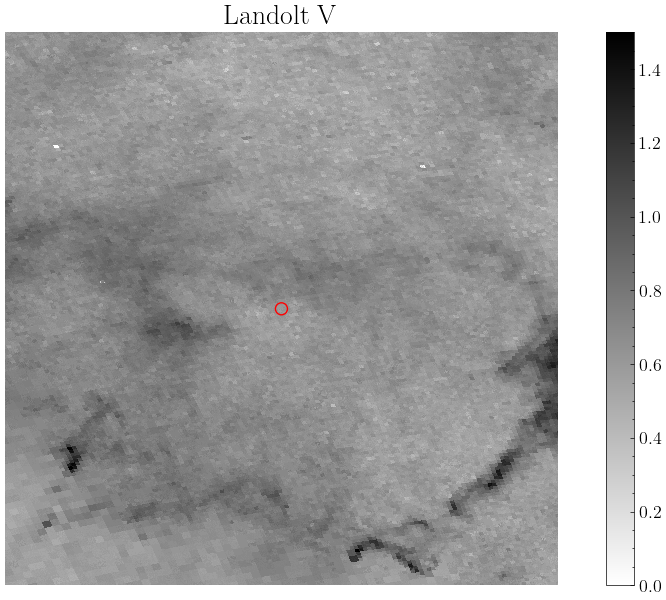

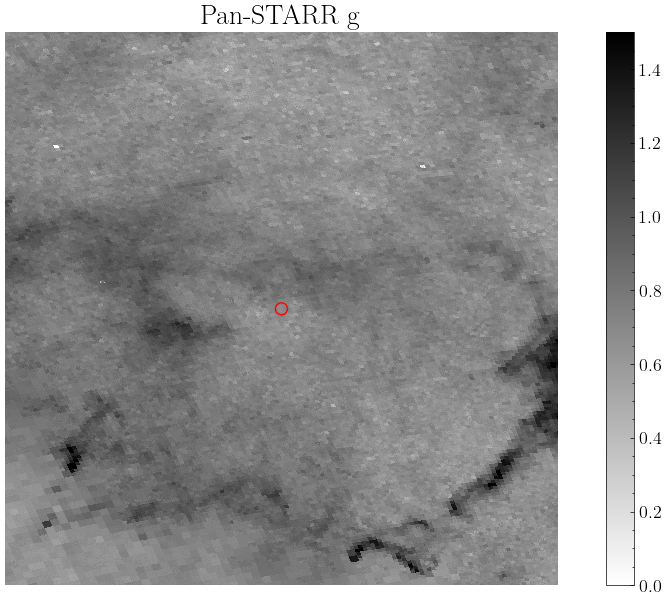

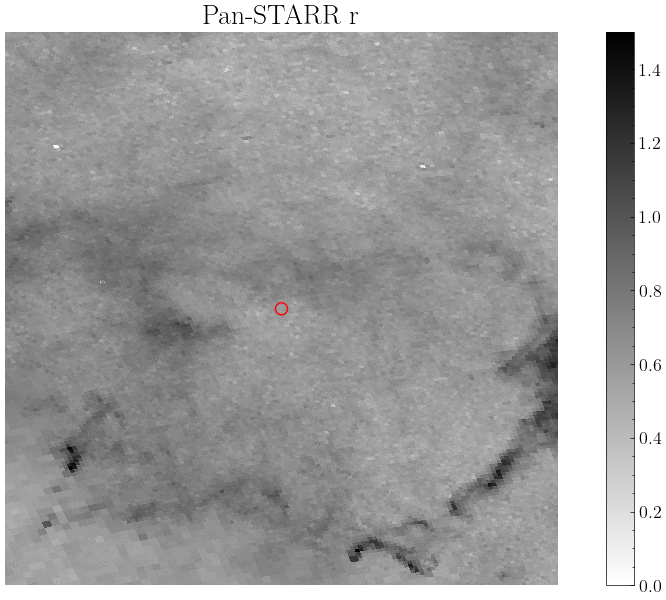

In [13]:
dustPlotsConfig = [
    ("Landolt B", Av_LandoltB),
    ("Landolt V", Av_LandoltV),
    ("Pan-STARR g", Av_PstarG),
    ("Pan-STARR r", Av_PstarR)
]

for title, av in dustPlotsConfig:
    plt.figure(figsize=(10, 6))
    plt.imshow(
        np.sqrt(av)[::,::-1], # sqrt to flatten, -1 slice to mirror across y axis
        cmap='binary',
        vmin=0, vmax=1.5,
        interpolation='nearest',
        aspect='equal',
        origin='lower'
    )
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=13)
    plt.scatter(len(raRange) / 2, len(decRange) / 2, marker='.', alpha=1, edgecolors='red', facecolors='none', s=300)
    plt.tight_layout()
    plt.axis('off')
    plt.title(title, fontsize=20)

# Extinction in PHOEBE

## Adopting $E(B-V)$ values into PHOEBE model

Flipping constraint to modify `ebv` instead of `Av` using results from `bayestar` module

In [14]:
b.flip_constraint(qualifier='ebv', solve_for='Av')

<ConstraintParameter: {Av@system} = {Rv@system} * {ebv@system} (solar units) => 0.0>

In [15]:
np.max(ebv).item()

0.1599999964237213

In [16]:
b.set_value(qualifier='ebv', value=np.max(ebv).item())
b.run_compute(model='ebv_gaia_extincted_max', overwrite=True)

b.set_value(qualifier='ebv', value=np.mean(ebv).item())
b.run_compute(model='ebv_gaia_extincted_mean', overwrite=True)

b.set_value(qualifier='ebv', value=np.min(ebv).item())
b.run_compute(model='ebv_gaia_extincted_min', overwrite=True)

100%|██████████| 104/104 [00:26<00:00,  3.87it/s]


<ParameterSet: 222 parameters | kinds: mesh, lc>

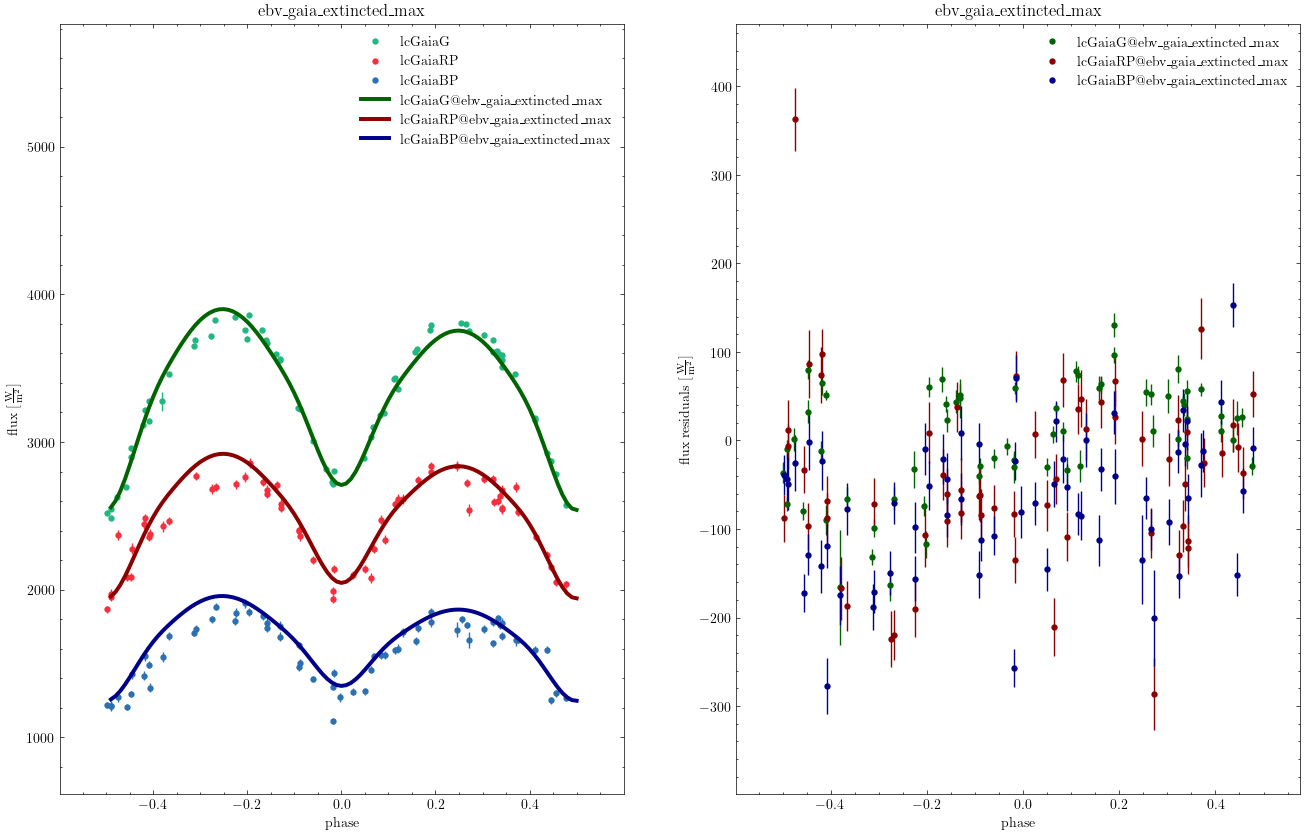

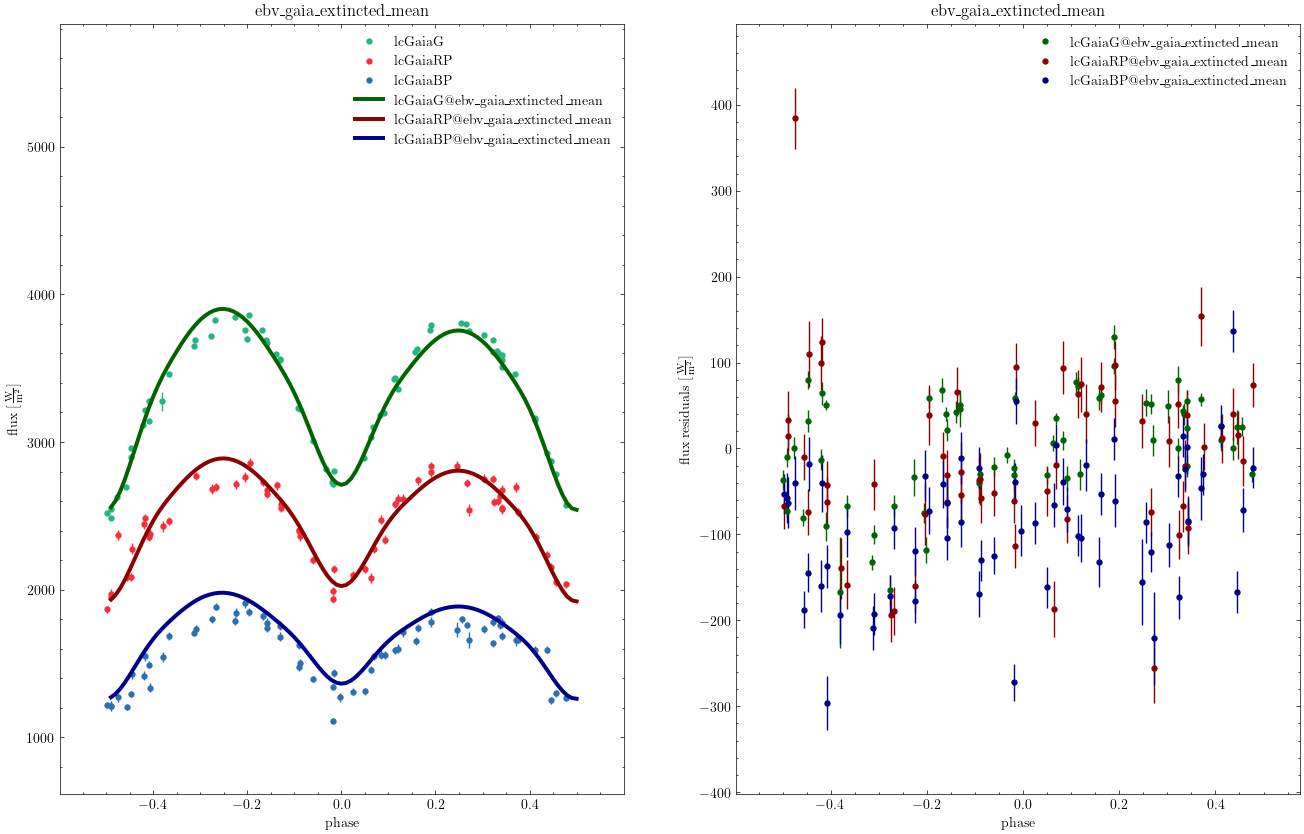

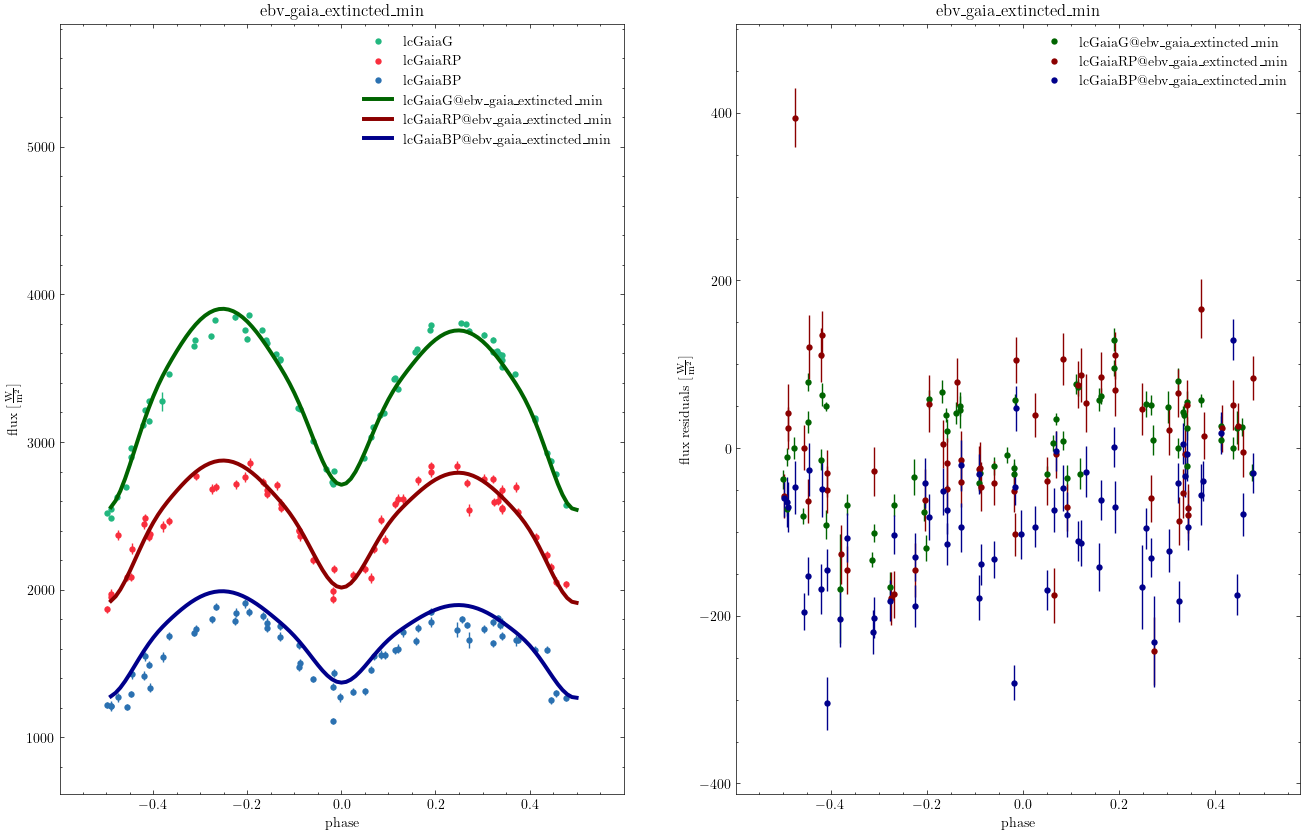

t0_gaia_model
	 Gaia (Raw) - 9387.031660396355
		 lcGaiaG - 1757.13019868005
		 lcGaiaRP - 2601.309004841172
		 lcGaiaBP - 5028.5924568751325
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_max
	 Gaia (Raw) - 3506.706090239245
		 lcGaiaG - 1770.4033172895904
		 lcGaiaRP - 730.2974512407828
		 lcGaiaBP - 1006.0053217088719
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_mean
	 Gaia (Raw) - 3653.815625746339
		 lcGaiaG - 1763.5207914011737
		 lcGaiaRP - 611.5164467061161
		 lcGaiaBP - 1278.7783876390492
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_min
	 Gaia (Raw) - 3778.951519702662
		 lcGaiaG - 1760.9496884580462
		 lcGaiaRP - 590.2484532592281
		 lcGaiaBP - 1427.7533779853877
------------------------------------------------
------------------------------------------------


In [17]:
for m in b.models:
    if 'ebv_gaia_extincted' in m:
        gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[gaiaDatasets], model=m, title=m, draw_title=True)

gen_utils.printAllModelsChi2(b)

## Adopting $A_V$ value obtained using Landolt:V reddening conversion

In [18]:
b.flip_constraint(qualifier='Av', solve_for='ebv')

<ConstraintParameter: {ebv@system} = {Av@system} / {Rv@system} (solar units) => 0.12999999523162842>

100%|██████████| 104/104 [00:27<00:00,  3.73it/s]


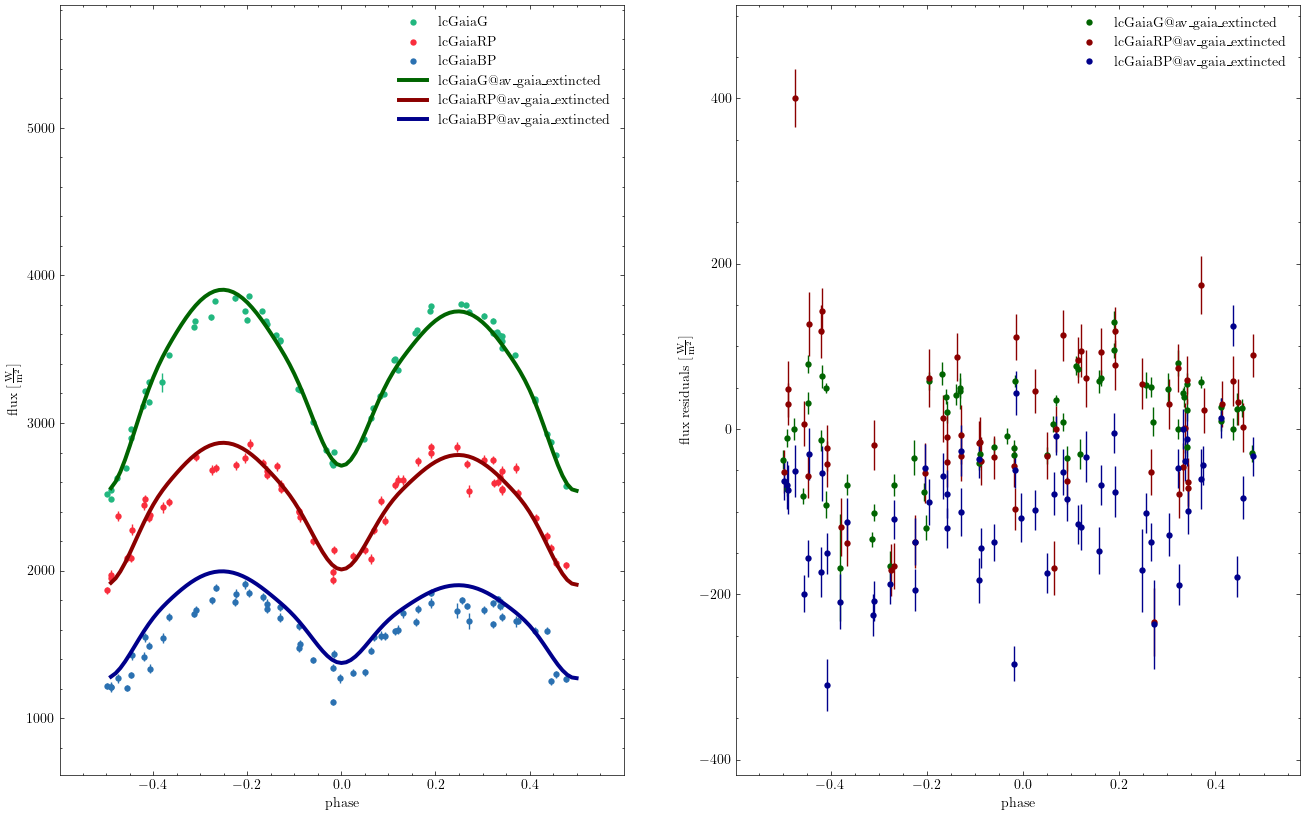

t0_gaia_model
	 Gaia (Raw) - 9387.031660396355
		 lcGaiaG - 1757.13019868005
		 lcGaiaRP - 2601.309004841172
		 lcGaiaBP - 5028.5924568751325
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_max
	 Gaia (Raw) - 3506.706090239245
		 lcGaiaG - 1770.4033172895904
		 lcGaiaRP - 730.2974512407828
		 lcGaiaBP - 1006.0053217088719
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_mean
	 Gaia (Raw) - 3653.815625746339
		 lcGaiaG - 1763.5207914011737
		 lcGaiaRP - 611.5164467061161
		 lcGaiaBP - 1278.7783876390492
------------------------------------------------
------------------------------------------------
ebv_gaia_extincted_min
	 Gaia (Raw) - 3778.951519702662
		 lcGaiaG - 1760.9496884580462
		 lcGaiaRP - 590.2484532592281
		 lcGaiaBP - 1427.7533779853877
------------------------------------------------
------------------------------------------------
av_gai

In [19]:
b.set_value(qualifier='Av', value=Av_LandoltV[len(raRange)//2, len(decRange)//2].item()) # dustmap centered on ATO object
b.run_compute(model='av_gaia_extincted', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[gaiaDatasets], model='av_gaia_extincted')
gen_utils.printAllModelsChi2(b)

# Use max $E(B - V)$ obtained from `bayestar`

Resulted in best fit to data without changing other model parameters.

In [20]:
b.flip_constraint(qualifier='ebv', solve_for='Av')

<ConstraintParameter: {Av@system} = {Rv@system} * {ebv@system} (solar units) => 0.38388001918792725>

100%|██████████| 104/104 [00:26<00:00,  3.97it/s]


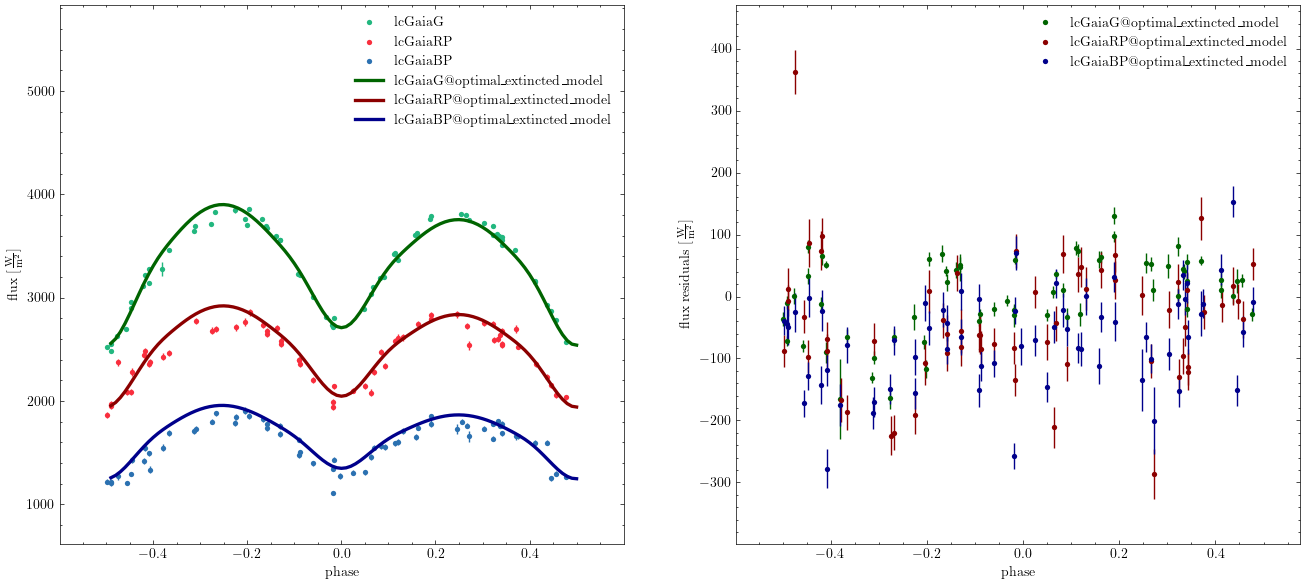

{'lcGaiaG-lcGaiaRP-lcGaiaBP': <Figure size 1600x700 with 2 Axes>}

In [21]:
b.set_value(qualifier='ebv', value=np.max(ebv).item())
b.run_compute(model='optimal_extincted_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=[gaiaDatasets], model='optimal_extincted_model')